# Problem 2

## Spectral graph teory: cuts, communities and conductance

In [1]:
import numpy as np
import networkx as nx 
from matplotlib import pyplot as plt

from itertools import combinations

from tqdm import tqdm

### Find the densest subgraph using the Charikar greedy algorithm

Firstly let's define the graph and some representations, also plotting it in ```networkx```. 

In [2]:
nodes = list(range(1,11))

edges = [
    (1,2),
    (1,3),
    (1,4),
    (1,7),
    (2,3),
    (2,4),
    (2,5),
    (3,4),
    (3,7),
    (4,5),
    (5,6),
    (5,9),
    (6,8),
    (6,9),
    (6,10),
    (7,8),
    (7,10),
    (8,9),
    (8,10),
    (9,10)
]

G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

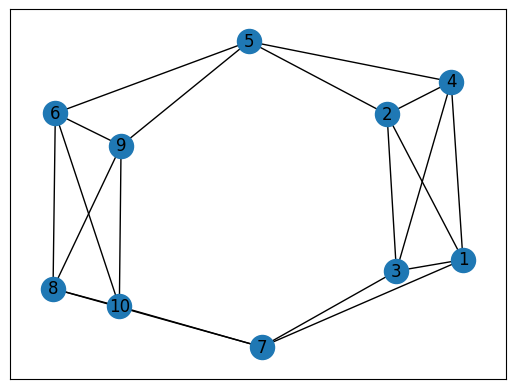

In [3]:
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos=pos)

In [4]:
# Adjacency matrix

A = np.zeros((10,10))

for e in edges:
    A[e[0] - 1, e[1] - 1] = 1
    A[e[1] - 1, e[0] - 1] = 1

# Degree matrix

D = np.diag(np.sum(A, axis = 0))

# Laplacian matrix

L = D - A

# Adjacency lists

adj_lists = {v:[] for v in nodes}

for e in edges:
    adj_lists[e[0]].append(e[1])
    adj_lists[e[1]].append(e[0])

In [5]:
adj_lists

{1: [2, 3, 4, 7],
 2: [1, 3, 4, 5],
 3: [1, 2, 4, 7],
 4: [1, 2, 3, 5],
 5: [2, 4, 6, 9],
 6: [5, 8, 9, 10],
 7: [1, 3, 8, 10],
 8: [6, 7, 9, 10],
 9: [5, 6, 8, 10],
 10: [6, 7, 8, 9]}

In [6]:
def Greedy_Densest_Subgraph(
        adj_lists:dict
        ) -> list:
    
    S = list(adj_lists.keys())

    S_G = list(adj_lists.keys())

    f_SG = 0.5*sum(map(lambda x: len(adj_lists[x]), adj_lists))/len(S)

    print(f_SG)
    
    while len(S) > 1:

        v = min(adj_lists, key = lambda k: len(adj_lists[k]))

        S.remove(v)

        adj_lists = {u : [node for node in adj_lists[u] if node != v] for u in list(adj_lists.keys()) if u != v}

        print(adj_lists)
        
        f_S = 0.5*sum(map(lambda x: len(adj_lists[x]), adj_lists))/len(S)
        
        print(f_S)
        
        if f_S >= f_SG:
               
               f_SG = f_S

               S_G = S

    return S_G, f_SG

In [7]:
Greedy_Densest_Subgraph(adj_lists)

2.0
{2: [3, 4, 5], 3: [2, 4, 7], 4: [2, 3, 5], 5: [2, 4, 6, 9], 6: [5, 8, 9, 10], 7: [3, 8, 10], 8: [6, 7, 9, 10], 9: [5, 6, 8, 10], 10: [6, 7, 8, 9]}
1.7777777777777777
{3: [4, 7], 4: [3, 5], 5: [4, 6, 9], 6: [5, 8, 9, 10], 7: [3, 8, 10], 8: [6, 7, 9, 10], 9: [5, 6, 8, 10], 10: [6, 7, 8, 9]}
1.625
{4: [5], 5: [4, 6, 9], 6: [5, 8, 9, 10], 7: [8, 10], 8: [6, 7, 9, 10], 9: [5, 6, 8, 10], 10: [6, 7, 8, 9]}
1.5714285714285714
{5: [6, 9], 6: [5, 8, 9, 10], 7: [8, 10], 8: [6, 7, 9, 10], 9: [5, 6, 8, 10], 10: [6, 7, 8, 9]}
1.6666666666666667
{6: [8, 9, 10], 7: [8, 10], 8: [6, 7, 9, 10], 9: [6, 8, 10], 10: [6, 7, 8, 9]}
1.6
{6: [8, 9, 10], 8: [6, 9, 10], 9: [6, 8, 10], 10: [6, 8, 9]}
1.5
{8: [9, 10], 9: [8, 10], 10: [8, 9]}
1.0
{9: [10], 10: [9]}
0.5
{10: []}
0.0


([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 2.0)

### Find a minimum cut

I decided to implement Karger's randomized algorithm to find a minimum cut. 

It is an algorithm that iteratively contracts the graphs performing a uniformly at random selection of an edge $(u,v)$ and collapsing this edge into a new node $uv$, up to the moment where there's only one cut left. It has nice probabilistic properties that are out of the purposes of this implementation. 

In this case the best representation of the graph is a list of edges and a list of nodes.

In [8]:
def node_merging(u,v):

    if type(u) != tuple:
        u = [u]
    else:
        u = list(u)

    if type(v) != tuple:
        v = [v]
    else:
        v = list(v)

    return tuple(u + v)

In [9]:
def Karger(E:list,
           V:list
           ):
    
    # Initialization

    E_ = E.copy()
    V_ = V.copy()
    
    while len(V_) > 2:
        
        # Random choice of an edge
        
        idx = np.random.choice(range(1,len(E_)), 1)[0]
        e = E_[idx]

        # Our supernode

        supernode = node_merging(e[0],e[1])
        V_.append(supernode)

        # Get rid of the edge

        V_.remove(e[0])
        V_.remove(e[1])
        E_.remove(e)

        # Connect the new retrieved super node

        trash_coll = []
        for edge in E_:
            new_edge = (0,0)
            if e[0] in edge:
                if edge[0] == e[0]:
                    trash_coll.append(edge)
                    new_edge = (supernode, edge[1])

                elif edge[1] == e[0]:
                    trash_coll.append(edge)
                    new_edge = (edge[0], supernode)

            elif e[1] in edge:
                if edge[0] == e[1]:
                    trash_coll.append(edge)
                    new_edge = (supernode, edge[1])

                elif edge[1] == e[1]:
                    trash_coll.append(edge)
                    new_edge = (edge[0], supernode)

            if new_edge[0] != new_edge[1]:
                E_.append(new_edge)                    
        for e in trash_coll:
            E_.remove(e)


    return V_

In [10]:
Karger(edges, nodes)

[7, (1, 2, 4, 5, 3, 6, 10, 8, 9)]

We are not interested in the probabilistic outcomes of the algorithm: however, let's have a look to the cuts retrieved by repeating the algorithm:  

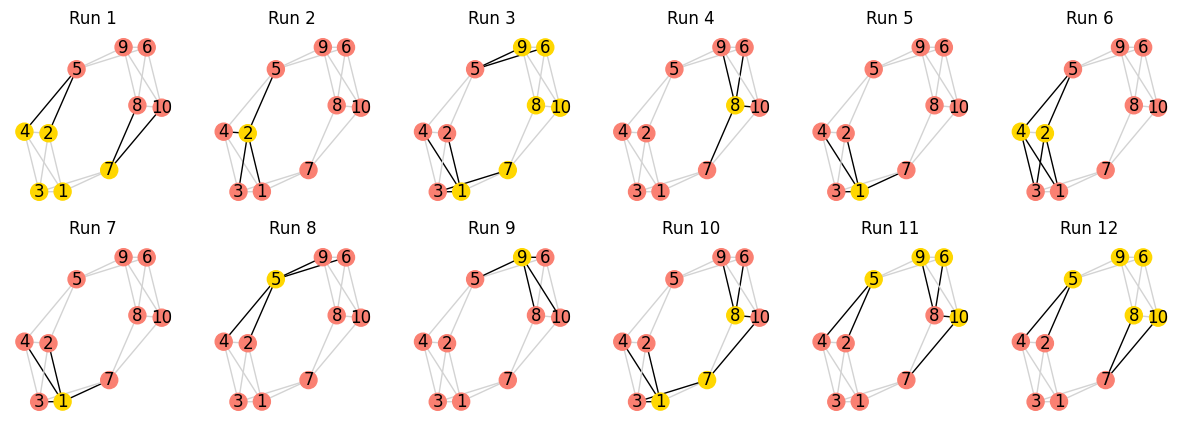

In [11]:
np.random.seed(4200)

cuts = []
for _ in range(12):
    cuts.append(Karger(edges, nodes))

# Slight correction on the structure of the cuts

for cut in cuts:
    if type(cut[0]) == int:
        cut[0] = tuple([cut[0]])
    elif type(cut[1]) == int:
        cut[1] = tuple([cut[1]])
    
fig, axes = plt.subplots(2, 6, figsize=(15, 5))
pos = nx.spring_layout(G, seed=4200)

for i, cut in enumerate(cuts):
    row = i // 6
    col = i % 6

    edge_colors = ['black' if ((u in cut[0] and v not in cut[0]) or (v in cut[0] and u not in cut[0])) else 'lightgrey' for u, v in G.edges()]

    nx.draw(G, 
            pos = pos, 
            ax=axes[row, col], 
            with_labels=True, 
            node_size = 150,
            node_color=['gold' if node in cut[0] else 'salmon' for node in nodes],
            edge_color=edge_colors)

    # Set title

    axes[row, col].set_title(f'Run {i+1}')

As we can see, in 12 runs the algorithm retrieves no cuts whose cut size is less than 4. We cannot have any confidence in saying that this is the minimum cut size, so we'll rely on spectral graph theory. 

### Show that Cheeger's inequality hold for this graph

Given the second smallest eigenvalue $\lambda_2$ of the graph laplacian, Cheeger's inequality states that the graph conductance $\phi_G$ is bounded as follows:

$$ \frac{\lambda_2}{2} \leq \phi_G \leq \lambda_2 $$

where the conductance is defined as the minimum among the conductance of all cuts, where a cut conductance is the cardinality of the cut over its volume as the minimum between the sum of the degrees of the nodes within one of the two partitions:

$$ \phi_G = \underset{C1 \subset V, C2 = V \setminus C1}{\mathrm{min}} \ \ \frac{|E(C1,C2)|}{\min\{ \sum_{i \in C1} d_i, \sum_{i \in C2} d_i\}} $$

Since the given graph is quite small, we can compute its conductance explicitely:

In [12]:
cuts_conductance = {}

for m in tqdm(range(1,6)):

    cuts = list(combinations(nodes, m))

    for cut in cuts:

        C1 = cut

        C2 = [node for node in nodes if node not in cut]

        E_C1C2 = len([e for e in edges if (e[0] in C1 and e[1] in C2) or (e[1] in C1 and e[0] in C2)])

        sum_d1 = sum(map(len, 
                         dict(
                             filter(
                                 lambda item: item[0] not in C1, adj_lists.items())).values()))
        
        sum_d2 = sum(map(len, 
                         dict(
                             filter(
                                 lambda item: item[0] not in C2, adj_lists.items())).values()))
        

        cuts_conductance[C1] = E_C1C2 / min((sum_d1, sum_d2))
                

100%|██████████| 5/5 [00:00<00:00, 384.48it/s]


In [13]:
min_cut, min_phi_G = min(cuts_conductance.items(), key = lambda x: x[1])

In [14]:
min_cut

(1, 2, 3, 4, 5)

In [15]:
min_phi_G

0.2

Now to check if Cheeger's inequality holds we need the second smallest eigenvalue of the normalized laplacian matrix: since our graph is $d$-regular, with $d = 4$ we have that 
$$ \mathcal{L} = \mathbb{I} - \frac{1}{d}A $$

In [16]:
# Normalized laplacian of a d-regular graph with d = 4

d = 4
L_ = np.eye(L.shape[0]) - A/d

# Eigendecomposition through numpy functions

lambdas, U = np.linalg.eig(L_)

In [17]:
# We call np.real over the eigenvalues to get rid of numerical problems with imaginary parts

lambda_2 = np.sort(np.real(lambdas))[1]

In [18]:
lambda_2

0.2500000000000001

In [19]:
(lambda_2/2 <= min_phi_G) & (min_phi_G <= np.sqrt(2*lambda_2))

True

### Find the cut that satisfies Cheeger's inequality

We are given a $d$-regular graph ($d = 4$), so we can use the ```SWEEPING``` algorithm we have seen during lectures.

This algorithm leverages the eigendecomposition of the normalized laplacian of an undirected $d$-regular graph $G(V,E)$, giving as output a cut $(C_1, C_2)$ minimizing the conductance. 

First of all we retrieve the eigendecomposition of the normalized laplacian for the graph, being as we said before
$$ \mathcal{L} = \mathbb{I} - \frac{1}{d}A $$

and we collect the eigenvector $v_2$ corresponding to the second smallest eigenvalue: according to ```numpy``` documentation, eigenvalues retrieved through ```linalg.eig``` are not necessarily sorted, so we have to sort them as well as we have to sort accordingly the eigenvectors, which are given in a matrix of column vectors. 

In [20]:
# Just repeating previous computations

d = 4
L_ = np.eye(L.shape[0]) - A/d

lambdas, U = np.linalg.eig(L_)

In [21]:
# We have to sort properly both the eigenvalues and the eigenvectors

idxs = np.argsort(np.real(lambdas))
lambdas = np.real(lambdas)[idxs]
U = np.real(U[:,idxs])

In [22]:
v_2 = U[:,1]

Now let's sort the nodes increasingly with respect to $v_2$:

In [23]:
nodes_sorted = np.argsort(v_2)

In [24]:
nodes_sorted

array([7, 8, 5, 9, 6, 4, 0, 2, 1, 3], dtype=int64)

In [25]:
v_2

array([ 3.53553391e-01,  3.53553391e-01,  3.53553391e-01,  3.53553391e-01,
        9.29592289e-18, -3.53553391e-01, -4.44460925e-17, -3.53553391e-01,
       -3.53553391e-01, -3.53553391e-01])

The next step is a loop over all the vertices sorted with respect to $v_2$. We consider the sorted vector to be $x_1 \leq x_2 \leq ... \leq x_n$, so that the index point to the respective vertex. 

Now we perform the "sweeping" step: we iterate over $i \in \{1,2,..,n -1\}$ and retrieve the conductance associated to all the cuts $C_1 = \{1,...,i\}, C_2 = V \backslash C_1$: then we retrieve the cut whose conductance is the minimum. 

In [26]:
phis = {}
C1 = []
C2 = nodes

for i in range(len(nodes)-1):
    
    # Do the sweeps between the two cuts

    C1.append(nodes_sorted[i]+1)
    C2.remove(nodes_sorted[i]+1)
    
    # As before collect the quantities need to compute conductance of the cut of interest
    
    E_C1C2 = len([e for e in edges if (e[0] in C1 and e[1] in C2) or (e[1] in C1 and e[0] in C2)])

    sum_d1 = sum(map(len, 
                        dict(
                            filter(
                                lambda item: item[0] not in C1, adj_lists.items())).values()))
    
    sum_d2 = sum(map(len, 
                        dict(
                            filter(
                                lambda item: item[0] not in C2, adj_lists.items())).values()))
    

    phis[tuple(C1)] = E_C1C2 / min((sum_d1, sum_d2))

In [27]:
phis

{(8,): 1.0,
 (8, 9): 0.75,
 (8, 9, 6): 0.5,
 (8, 9, 6, 10): 0.25,
 (8, 9, 6, 10, 7): 0.2,
 (8, 9, 6, 10, 7, 5): 0.25,
 (8, 9, 6, 10, 7, 5, 1): 0.5,
 (8, 9, 6, 10, 7, 5, 1, 3): 0.75,
 (8, 9, 6, 10, 7, 5, 1, 3, 2): 1.0}

In [28]:
min_cut_SW, min_phi_G_SW = min(phis.items(), key = lambda x: x[1])

In [29]:
min_cut_SW

(8, 9, 6, 10, 7)

In [30]:
min_phi_G_SW

0.2

We found the exactly same cut: we just got in output the complementary set of the one retrieved with the brutal enumeration. This algorihtm yields a good approximation for the computation of the conductance, providing an heuristic for a NP-hard problem that drops drastically the computation complexity. 

__________